In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner

file_name = 'q10_data.txt'

# Load the data from the text file
data = np.loadtxt(file_name, delimiter=None) 

# Split the data into separate arrays
measurement_number = data[:, 0]
x = data[:, 1]
y = data[:, 2]
sigma = data[:, 3]

# Define the model: y = a*x^2 + b*x + c
def model(theta, x):
    a, b, c = theta
    return a * x**2 + b * x + c

# Define the log likelihood function
def log_likelihood(theta, x, y, sigma):
    model_y = model(theta, x)
    return -0.5 * np.sum((((y - model_y) / sigma) ** 2) + (np.log(2 * np.pi * sigma**2)))

# Define the log prior function
def log_prior(theta):
    a, b, c = theta
    if -1000 < a < 1000 and -1000 < b < 1000 and -1000 < c < 1000:
        return 0.0
    return -np.inf

# Define the log probability function
def log_probability(theta, x, y, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, sigma)


# Set up the MCMC sampler
nwalkers = 50
ndim = 3
nsteps = 4000
guess = [1.0, 1.0, 1.0]
pos = guess + 1e-4 * np.random.randn(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, sigma))


# Run the MCMC chains
sampler.run_mcmc(pos, nsteps)

# Get the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)
#print("Shape of samples:", samples.shape)


# Compute the quantiles
quantiles = np.percentile(samples, [16, 50, 84], axis=0)
medians = quantiles[1]
one_sigma = np.diff(quantiles, axis=0)

# Results
print("Best-fit values (medians):", medians)
print("\n One-sigma uncertainties:", one_sigma)

Best-fit values (medians): [-7.82414563e-03  3.72268463e+00  1.81170318e+01]

 One-sigma uncertainties: [[9.21895787e-04 3.22943534e-01 2.65102427e+01]
 [9.26772168e-04 3.19313539e-01 2.73353479e+01]]


Plot to show all Markov chains

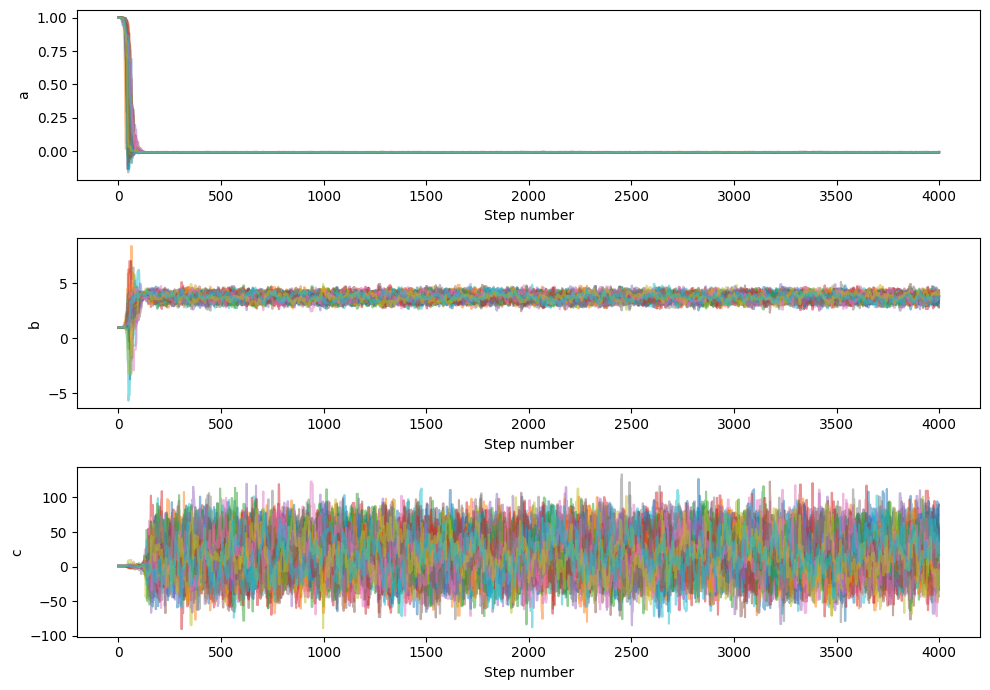

In [69]:
# Plot all chains
plt.figure(figsize=(10, 7))
for i in range(ndim):
    plt.subplot(3, 1, i+1)
    for walker in range(nwalkers):
        plt.plot(sampler.chain[walker, :, i], alpha=0.5)
    plt.xlabel("Step number")
    plt.ylabel(["a", "b", "c"][i])
plt.tight_layout()
plt.show()


Plot to show the joint and marginalised posterior PDFs for the three model parameters

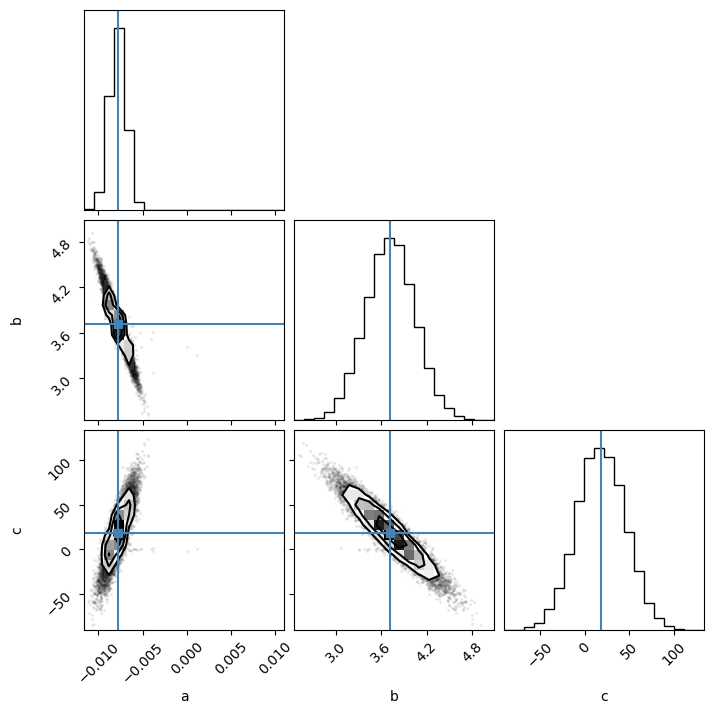

In [70]:
# Use corner library to make a plot showing the joint and marginalised posterior PDFs
corner_fig = corner.corner(samples, labels=["a", "b", "c"], truths=medians)
plt.show()

Plot to show the data with the best-fit model and 200 models randomly chosen from the posterior

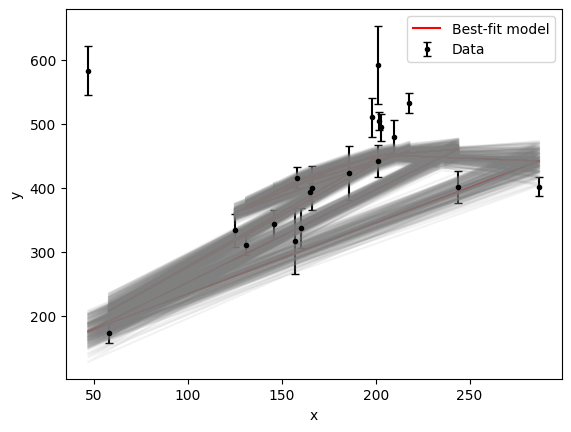

In [71]:
# Plot the data with the best-fit model and 200 models randomly chosen from the posterior
plt.errorbar(x, y, yerr=sigma, fmt=".k", capsize=3, label="Data")

# Best-fit model
best_fit = model(medians, x)
plt.plot(x, best_fit, label="Best-fit model", color="red")

# 200 models from the posterior
inds = np.random.randint(len(samples), size=200)
for ind in inds:
    sample = samples[ind]
    plt.plot(x, model(sample, x), color="grey", alpha=0.1)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()